In [50]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
# for data preparation
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
import warnings
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
warnings.filterwarnings("ignore")

In [51]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return MAE,RMSE

def plot_results(y,ypred,title=None):
    plt.figure(figsize=(25,5))
    plt.plot(y,label='actual')
    plt.plot(ypred,label='predicted')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()
    

In [52]:
def init_model(n):
    model = Sequential()
    model.add(LSTM(units=40, return_sequences=True, input_shape=(n,1), activation='relu'))
    model.add(Dropout(0.2)) # To prevent overfitting
    model.add(LSTM(units=40, return_sequences=True,activation='relu'))
    model.add(Dropout(0.2)) # To prevent overfitting
    model.add(LSTM(units=40))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    return model
# history = model.fit(x_train, y_train, epochs=50, batch_si


In [53]:
def prepare_dataset(df_next_day):
    # df_next_day[df_next_day.columns.difference(['sentiment'])] = df_next_day[df_next_day.columns.difference(['sentiment'])].fillna(method='bfill')
    # df_next_day.loc[:, 'sentiment'] = df_next_day['sentiment'].fillna(df_next_day['sentiment'].mode(),inplace=False, downcast='infer')
    
    # nan_percentages = df_next_day.isna().sum() / len(df_next_day)

    # # If more than 50% of the rows are NaN, drop the column
    # for column in df_next_day.columns:
    #     if nan_percentages[column] > 0.5:
    #         df_next_day = df_next_day.drop(column, axis=1)

    # # Otherwise, drop the rows with NaN values
    # df_next_day = df_next_day.dropna(axis=0)
    test_df = df_next_day[df_next_day['Date'] >= '2022-10-01'] # need change to more dynamic 
    train_df = df_next_day[df_next_day['Date'] < '2022-10-01']
    print(f'size of train dataset: {len(train_df)}')
    print(f'size of test dataset: {len(test_df)}')

    X = train_df.drop(['Date','next_day_closing_price'],axis=1)
    y = train_df['next_day_closing_price'].to_numpy().reshape(-1,1)

    

    X_scaler = MinMaxScaler()
    X_scaled =  X_scaler.fit_transform(X)

    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y)
    return X_scaled, y_scaled, test_df, X_scaler, y_scaler, test_df

In [54]:
def cross_val(X, y):
    mape_lst = []
    mae_lst = []
    rmse_lst =[]

    # Define the number of splits and the window size
    n_splits = 3

    # Initialize the time series split
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Perform rolling forward cross-validation
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]        

    
        print('Start New Training')
        # Fit the model on the training data
        n= X_train.shape[1]
        model = init_model(n)
        history = model.fit(X_train, y_train, epochs=50, batch_size=32)

        # Evaluate the model on the test data
        y_pred = model.predict(X_test)
        
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mape_lst.append(mape)
        print("Mean Absolute Percentage Error:", mape)
        
        mae, rmse = calculate_metrics(y_test, y_pred)
        mae_lst.append(mae)
        rmse_lst.append(rmse)
        print("Mean Absolute Error:", mae)
        print("Root Mean Squared Error:", rmse)
        
        plot_results(y_test, y_pred, 'val-result')
        print('End Training')
    return model
    

In [87]:

def predict(model, test_df, X_scaler, y_scaler):
    X_test = test_df.drop(['Date','next_day_closing_price'],axis=1)
    y_test = test_df['next_day_closing_price']
    X_test_scaled = X_scaler.transform(X_test)
    
    #Predict model based on test data
    y_pred = model.predict(X_test_scaled)
    y_pred = y_scaler.inverse_transform(y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    print("Mean Absolute Percentage Error:", mape)

    mae, rmse = calculate_metrics(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    y_range = np.max(y_test) - np.min(y_test)

    # Normalize RMSE
    norm_rmse = rmse / y_range

    print('Normalized RMSE:', norm_rmse)
    predicted_df = pd.DataFrame(y_pred, columns=['predicted_price'])
    res_df = pd.concat([test_df.reset_index(), predicted_df], axis = 1)
    plt.figure(figsize=(25, 5))
    plt.plot(res_df['next_day_closing_price'], color="black", label="Actual Prices")
    plt.plot(res_df['predicted_price'], color="green", label="Predicted prices")
    plt.xlabel('Time')
    plt.ylabel("Price")
    plt.title("GME Stock Prediction using LSTM")
    plt.legend(loc="upper left")
    plt.show()

    return res_df

size of train dataset: 945
size of test dataset: 78
Start New Training
Epoch 1/50


2023-04-01 17:50:53.265629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 17:50:53.267887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 17:50:53.269376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 5s 11ms/step - loss: 1.2478e-04 - root_mean_squared_error: 0.0112 - mae: 0.0089
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 9.5004e-05 - root_mean_squared_error: 0.0097 - mae: 0.0080
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 7.6747e-05 - root_mean_squared_error: 0.0088 - mae: 0.0073
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 6.9822e-05 - root_mean_squared_error: 0.0084 - mae: 0.0072
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 6.5915e-05 - root_mean_squared_error: 0.0081 - mae: 0.0065
Epoch 6/50
8/8 [==============================] - 0s 10ms/step - loss: 6.3949e-05 - root_mean_squared_error: 0.0080 - mae: 0.0067
Epoch 7/50
8/8 [==============================] - 0s 10ms/step - loss: 4.6464e-05 - root_mean_squared_error: 0.0068 - mae: 0.0055
Epoch 8/50
8/8 [==============================] - 0s 10ms/step - loss: 3.1467e-05 - root_mean_squared_

2023-04-01 17:51:03.257236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 17:51:03.259993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 17:51:03.261818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step
Mean Absolute Percentage Error: inf
Mean Absolute Error: 0.001136570412263218
Root Mean Squared Error: 0.0017011220058663235


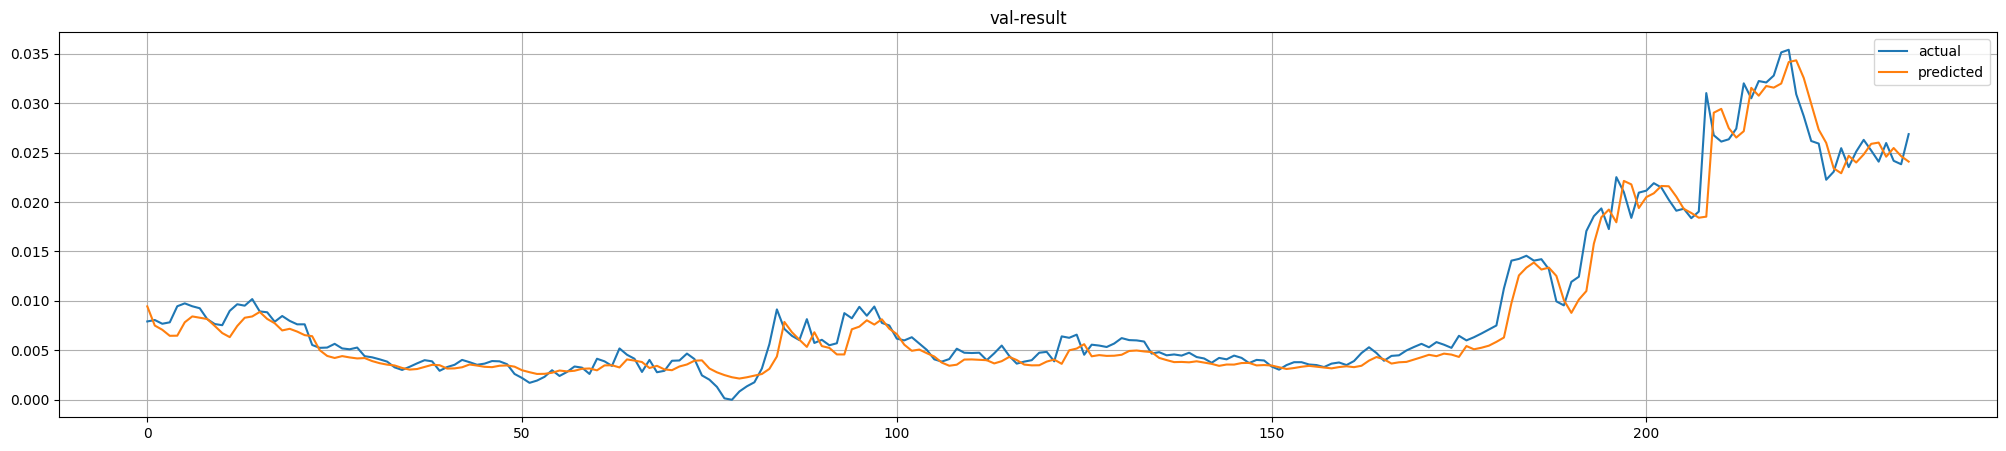

End Training
Start New Training
Epoch 1/50


2023-04-01 17:51:04.243299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 17:51:04.245068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 17:51:04.247183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 5s 11ms/step - loss: 1.0524e-04 - root_mean_squared_error: 0.0103 - mae: 0.0082
Epoch 2/50
15/15 [==============================] - 0s 19ms/step - loss: 8.2968e-05 - root_mean_squared_error: 0.0091 - mae: 0.0076
Epoch 3/50
15/15 [==============================] - 0s 11ms/step - loss: 8.2545e-05 - root_mean_squared_error: 0.0091 - mae: 0.0074
Epoch 4/50
15/15 [==============================] - 0s 10ms/step - loss: 7.7305e-05 - root_mean_squared_error: 0.0088 - mae: 0.0072
Epoch 5/50
15/15 [==============================] - 0s 13ms/step - loss: 7.2055e-05 - root_mean_squared_error: 0.0085 - mae: 0.0071
Epoch 6/50
15/15 [==============================] - 0s 10ms/step - loss: 6.6057e-05 - root_mean_squared_error: 0.0081 - mae: 0.0066
Epoch 7/50
15/15 [==============================] - 0s 10ms/step - loss: 4.6204e-05 - root_mean_squared_error: 0.0068 - mae: 0.0052
Epoch 8/50
15/15 [==============================] - 0s 10ms/step - loss: 2.9082e-05 - r

2023-04-01 17:51:18.802413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 17:51:18.804174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 17:51:18.806289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step
Mean Absolute Percentage Error: 32.72755773764137
Mean Absolute Error: 0.1567913317792098
Root Mean Squared Error: 0.18684015502022877


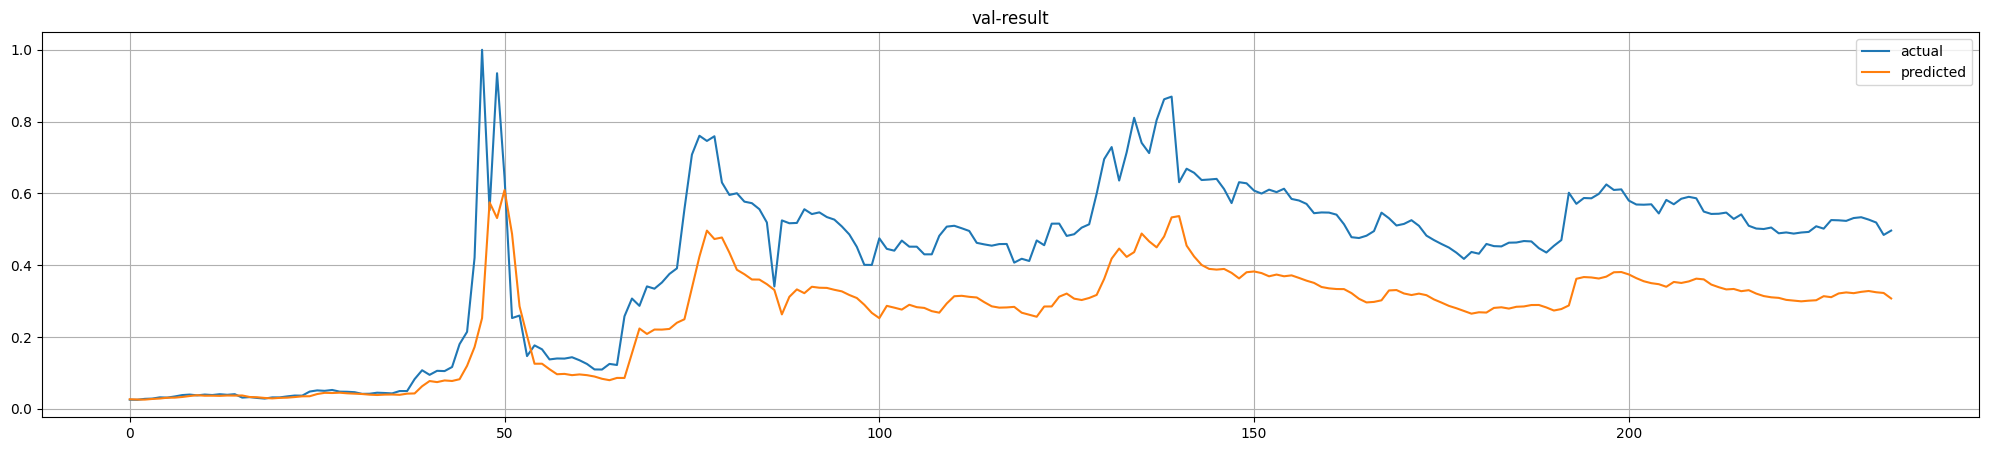

End Training
Start New Training
Epoch 1/50


2023-04-01 17:51:19.711760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 17:51:19.713592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 17:51:19.715116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

23/23 [==============================] - 5s 11ms/step - loss: 0.0485 - root_mean_squared_error: 0.2203 - mae: 0.1620
Epoch 2/50
23/23 [==============================] - 0s 16ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - mae: 0.0786
Epoch 3/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0052 - root_mean_squared_error: 0.0719 - mae: 0.0335
Epoch 4/50
23/23 [==============================] - 0s 15ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - mae: 0.0343
Epoch 5/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - mae: 0.0275
Epoch 6/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0038 - root_mean_squared_error: 0.0612 - mae: 0.0322
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - mae: 0.0246
Epoch 8/50
23/23 [==============================] - 0s 11ms/step - loss: 0.0029 - root_mean_squared_error: 0.0543 -

2023-04-01 17:51:37.886278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 17:51:37.887967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 17:51:37.889884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step
Mean Absolute Percentage Error: 6.367268302904451
Mean Absolute Error: 0.02370694433821602
Root Mean Squared Error: 0.030104153305079522


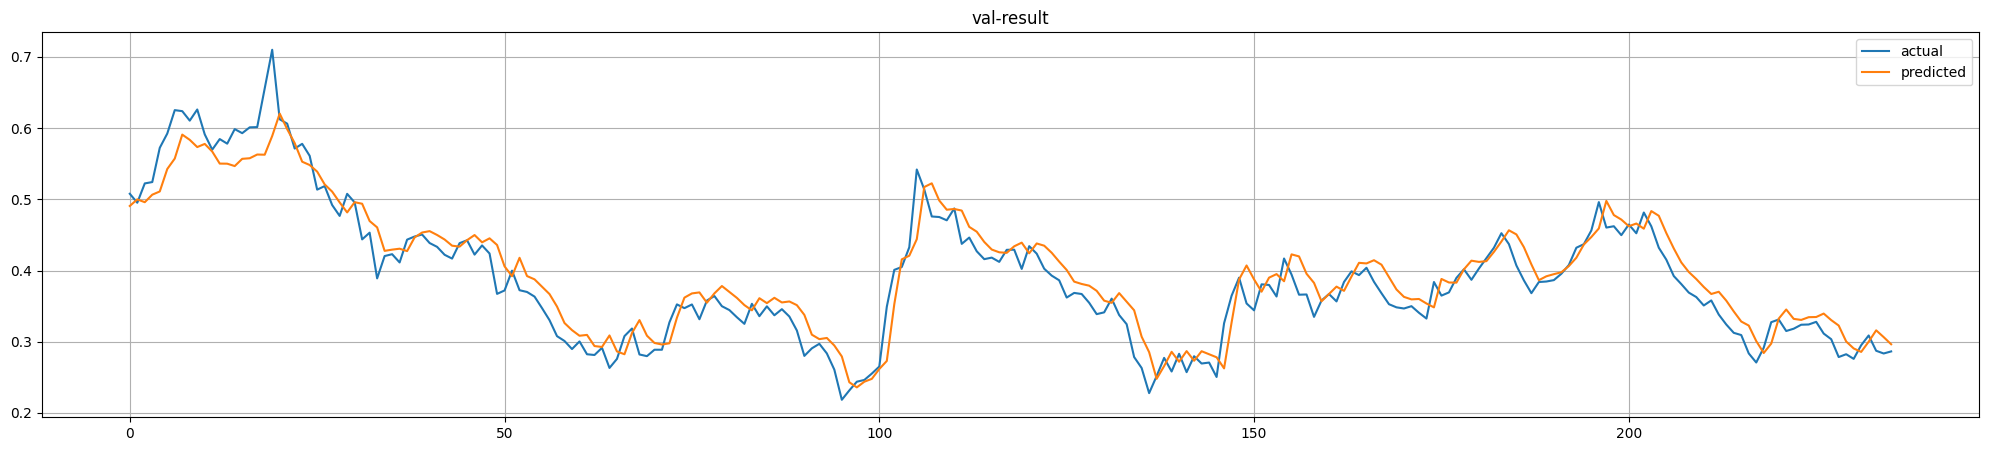

End Training
3/3 [==============================] - 0s 6ms/step
Mean Absolute Percentage Error: 19.102688072166583
Mean Absolute Error: 1.2245148756565187
Root Mean Squared Error: 1.525222387983045
Normalized RMSE: 0.1253264074298602


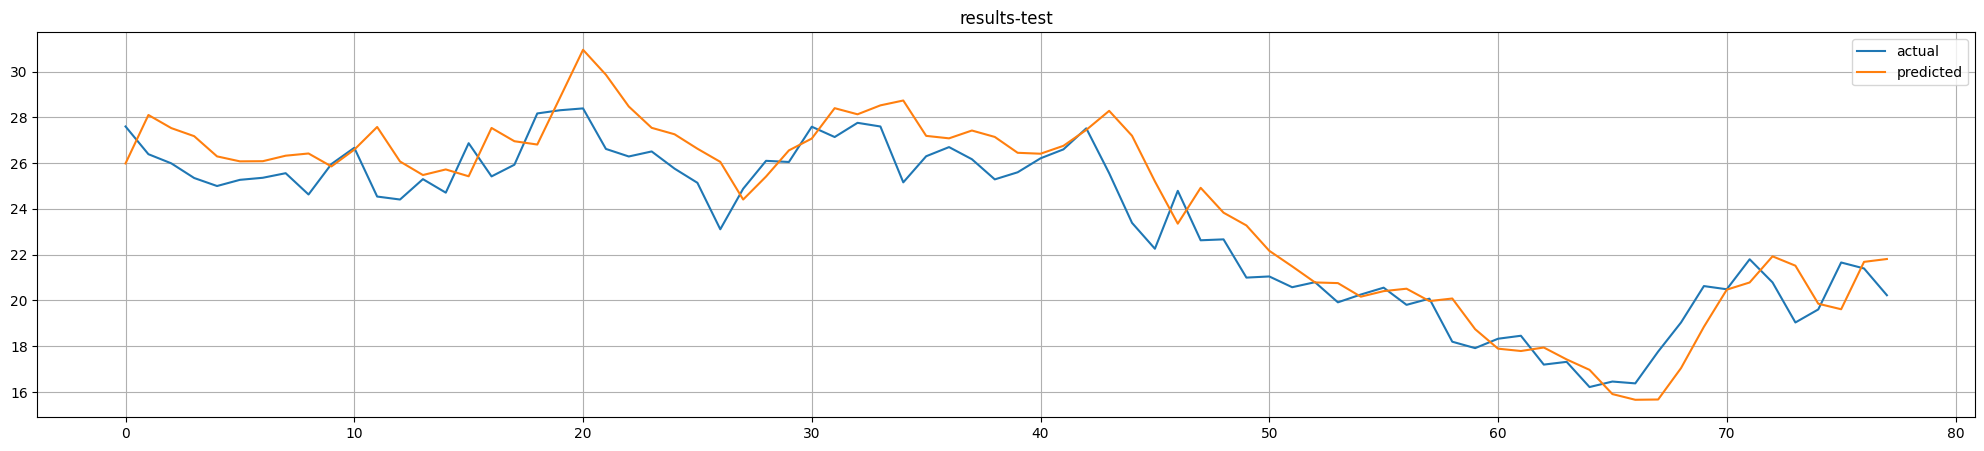

In [56]:
df_next_day = pd.read_csv('final_GME_data.csv')
X_scaled, y_scaled, test_df, X_scaler, y_scaler, test_df = prepare_dataset(df_next_day)
model = cross_val(X_scaled, y_scaled)


3/3 [==============================] - 0s 4ms/step
Mean Absolute Percentage Error: 19.102688072166583
Mean Absolute Error: 1.2245148756565187
Root Mean Squared Error: 1.525222387983045
Normalized RMSE: 0.1253264074298602


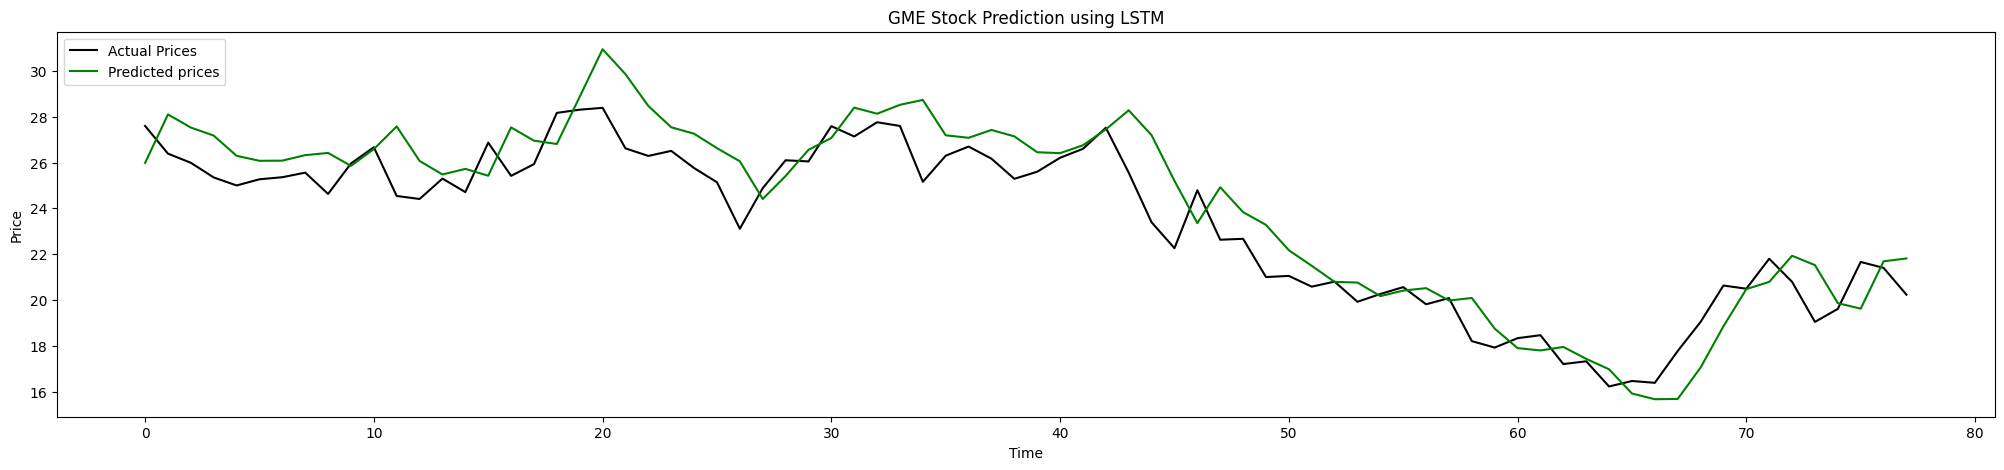

In [88]:
res_df = predict(model, test_df, X_scaler, y_scaler)

In [80]:
## To save or load the model uncomment this
from keras.models import load_model
# # save the model 
# model.save('gme_model.h5')
# # load the model
# model = load_model('gme_model.h5')

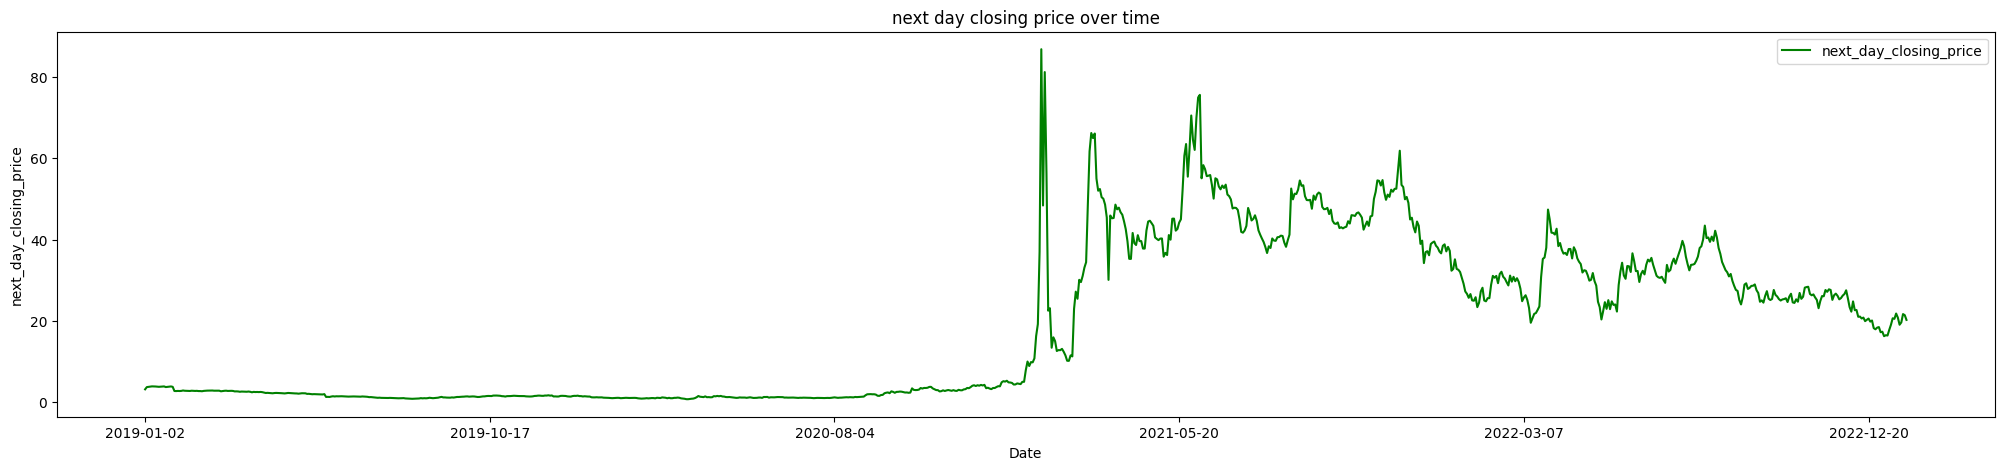

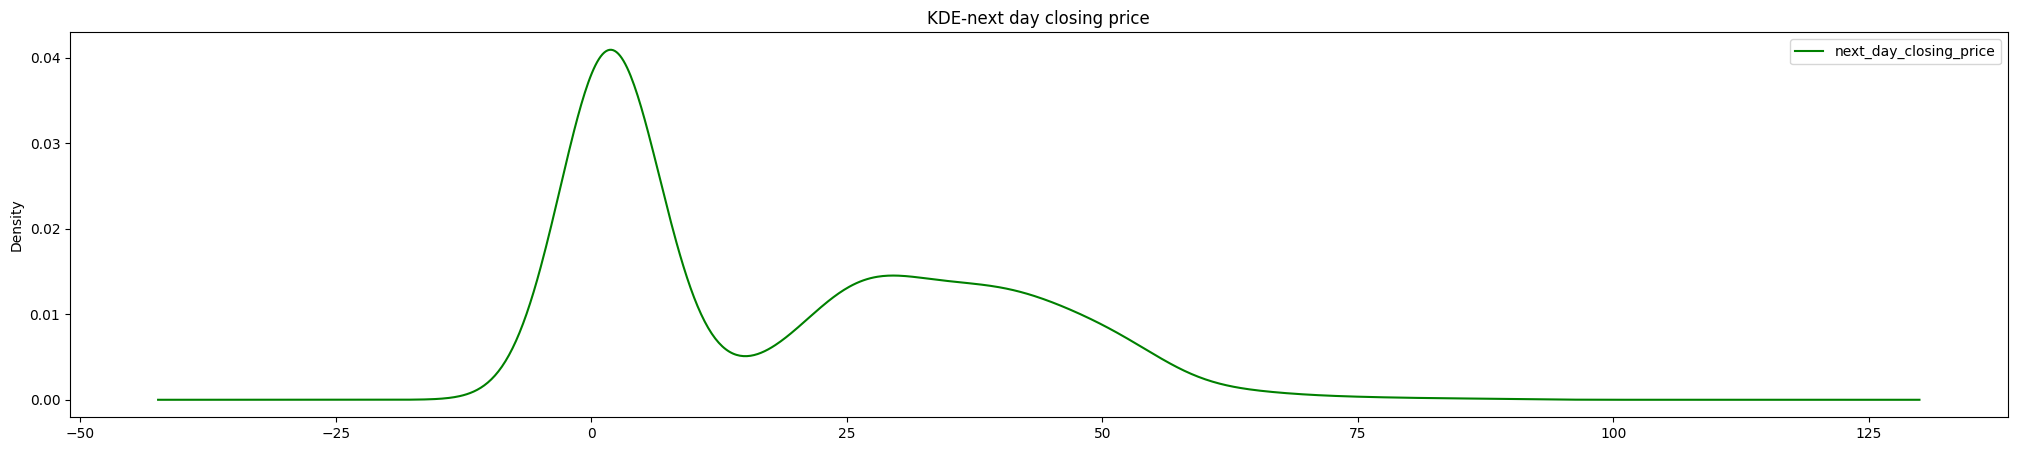

In [95]:
import random
def plot_data(df,feature_name,exclude_feature='next_day_closing_price'):
    
    df.plot(x='Date',y=feature_name,figsize=(25,5),grid=False,color='green')
    plt.title(f'{feature_name.replace("_"," ")} over time')
    plt.ylabel(feature_name)
    plt.show()

    df.plot(kind='kde',y=feature_name,figsize=(25,5),grid=False,color='green')
    plt.title(f'KDE-{feature_name.replace("_"," ")}')
    plt.show()
plot_data(df_next_day, feature_name='next_day_closing_price')